In [22]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
import numpy as np
print(np.kron([1,-1], [1,-1]))

[ 1 -1 -1  1]


In [23]:
# runtime imports
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import QasmSimulator, AerSimulator

backend = QasmSimulator()

In [25]:
hamiltonian = SparsePauliOp.from_list(
    [("II", -0.5597), ("IZ", 0.1615), ("ZI", -0.0166), ("ZZ", 0.4148), ("YY", 0.1266), ("XX", 0.1226)]
)

In [44]:
print(hamiltonian)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'YY', 'XX'],
              coeffs=[-0.5597+0.j,  0.1615+0.j, -0.0166+0.j,  0.4148+0.j,  0.1266+0.j,
  0.1226+0.j])


In [90]:
obsv_list = [
    [SparsePauliOp(['II'], [-0.5597])],
    [SparsePauliOp(['IZ'], [ 0.1615])],
    [SparsePauliOp(['ZI'], [-0.0166])],
    [SparsePauliOp(['ZZ'], [ 0.4148])],
    [SparsePauliOp(['YY'], [ 0.1266])],
    [SparsePauliOp(['XX'], [ 0.1266])]
]
print(obsv_list)

[[SparsePauliOp(['II'],
              coeffs=[-0.5597+0.j])], [SparsePauliOp(['IZ'],
              coeffs=[0.1615+0.j])], [SparsePauliOp(['ZI'],
              coeffs=[-0.0166+0.j])], [SparsePauliOp(['ZZ'],
              coeffs=[0.4148+0.j])], [SparsePauliOp(['YY'],
              coeffs=[0.1266+0.j])], [SparsePauliOp(['XX'],
              coeffs=[0.1266+0.j])]]


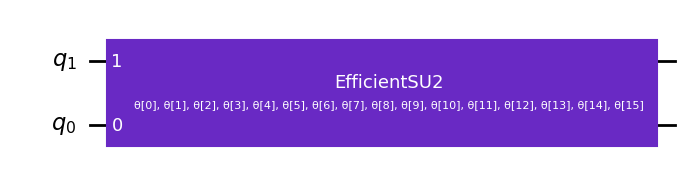

In [91]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw()

In [92]:
num_params = ansatz.num_parameters

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [101]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "energies":[]
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, obsv_list, [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    cost_history_dict['energies'].append(result[0].data.evs)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [102]:
x0 = 2 * np.pi * np.random.random(num_params)

In [103]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: [-0.5597]]
Iters. done: 2 [Current cost: [-0.5597]]
Iters. done: 3 [Current cost: [-0.5597]]
Iters. done: 4 [Current cost: [-0.5597]]
Iters. done: 5 [Current cost: [-0.5597]]
Iters. done: 6 [Current cost: [-0.5597]]
Iters. done: 7 [Current cost: [-0.5597]]
Iters. done: 8 [Current cost: [-0.5597]]
Iters. done: 9 [Current cost: [-0.5597]]
Iters. done: 10 [Current cost: [-0.5597]]
Iters. done: 11 [Current cost: [-0.5597]]
Iters. done: 12 [Current cost: [-0.5597]]
Iters. done: 13 [Current cost: [-0.5597]]
Iters. done: 14 [Current cost: [-0.5597]]
Iters. done: 15 [Current cost: [-0.5597]]
Iters. done: 16 [Current cost: [-0.5597]]
Iters. done: 17 [Current cost: [-0.5597]]
Iters. done: 18 [Current cost: [-0.5597]]
Iters. done: 19 [Current cost: [-0.5597]]
Iters. done: 20 [Current cost: [-0.5597]]
Iters. done: 21 [Current cost: [-0.5597]]
Iters. done: 22 [Current cost: [-0.5597]]
Iters. done: 23 [Current cost: [-0.5597]]
Iters. done: 24 [Current cost: [-0.5597]]
I

In [104]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5597
       x: [ 4.619e-01  1.673e+00 ...  1.212e+00  6.748e-01]
    nfev: 97
   maxcv: 0.0


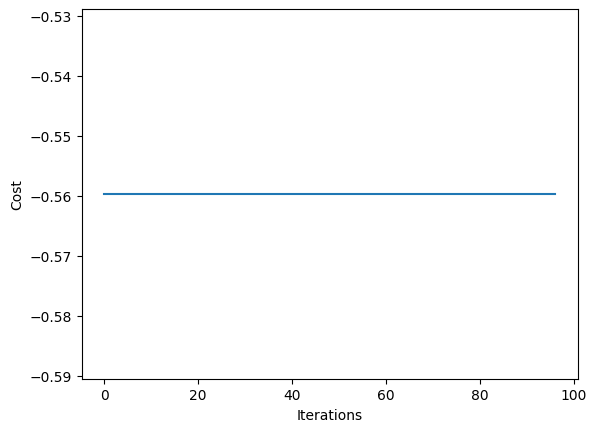

In [105]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [106]:
evs = np.array(cost_history_dict['energies'])
print(evs)
# print(evs[0])
# print(np.mean(evs[0]))

[[[-5.59700000e-01]
  [-1.54245117e-01]
  [ 3.37187500e-03]
  [ 1.00864453e-01]
  [ 2.26866211e-02]
  [-3.35663086e-02]]

 [[-5.59700000e-01]
  [-7.71225586e-02]
  [ 3.93115234e-03]
  [ 6.46099609e-02]
  [ 4.33951172e-02]
  [-3.75225586e-02]]

 [[-5.59700000e-01]
  [-1.17734131e-01]
  [ 6.97880859e-03]
  [ 2.26033594e-01]
  [ 5.73656250e-02]
  [-7.52923828e-02]]

 [[-5.59700000e-01]
  [-1.44703369e-01]
  [ 4.37695313e-03]
  [ 7.02810547e-02]
  [-2.42938477e-02]
  [-4.10460937e-02]]

 [[-5.59700000e-01]
  [-1.05195801e-01]
  [ 8.97275391e-03]
  [ 3.04821289e-01]
  [ 6.89252930e-02]
  [-7.29433594e-02]]

 [[-5.59700000e-01]
  [-1.06220947e-01]
  [ 7.19765625e-03]
  [ 1.01066992e-01]
  [-6.53399414e-02]
  [-3.09082031e-03]]

 [[-5.59700000e-01]
  [-1.11346680e-01]
  [ 6.80859375e-04]
  [ 2.99757812e-02]
  [ 3.12791016e-02]
  [ 4.34569336e-02]]

 [[-5.59700000e-01]
  [-9.46289063e-02]
  [ 4.53095703e-03]
  [ 8.81044922e-02]
  [ 7.05943359e-02]
  [-5.93437500e-03]]

 [[-5.59700000e-01]
  [-

In [107]:
print(len(cost_history_dict['cost_history']))
print(cost_history_dict['cost_history'])

97
[array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array([-0.5597]), array(

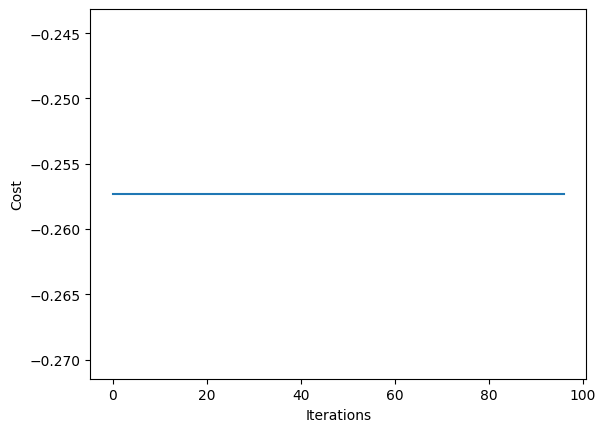

In [108]:
energy = np.array(cost_history_dict['cost_history']) + 0.3023869942
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), energy)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()